In [1]:
import os
import re
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader

import optuna
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search.basic_variant import BasicVariantGenerator

import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import utils_fn
import network
from params import *
from train_eval import *

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

#### Load train/valid/test set and create Data Loader

In [3]:
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64
INP_SHAPE = [2, 232, 10, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset_split_subj.pt', weights_only=False)#, map_location=torch.device(device)
val_dataset = torch.load('data/val_dataset_split_subj.pt', weights_only=False)#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset_split_subj.pt', weights_only=False)#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=1)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

x = next(iter(train_loader))[0]

print(f"\nShape of each element in the dataloader: {x.shape}")
print(f"Number of elements in train - valid - test set: {len(train_dataset)} - {len(val_dataset)} - {len(test_dataset)}")

Using cuda device

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])
Number of elements in train - valid - test set: 1680 - 138 - 182


#### Plot some examples

In [16]:
ACTIVITIES = ["WALKING", "RUNNING", "SITTING", "HANDS"]
class_enc = {a:[i] for i, a in enumerate(ACTIVITIES)}
class_dec = {int(v[0]): k for k, v in class_enc.items()}
class_dec

{0: 'WALKING', 1: 'RUNNING', 2: 'SITTING', 3: 'HANDS'}

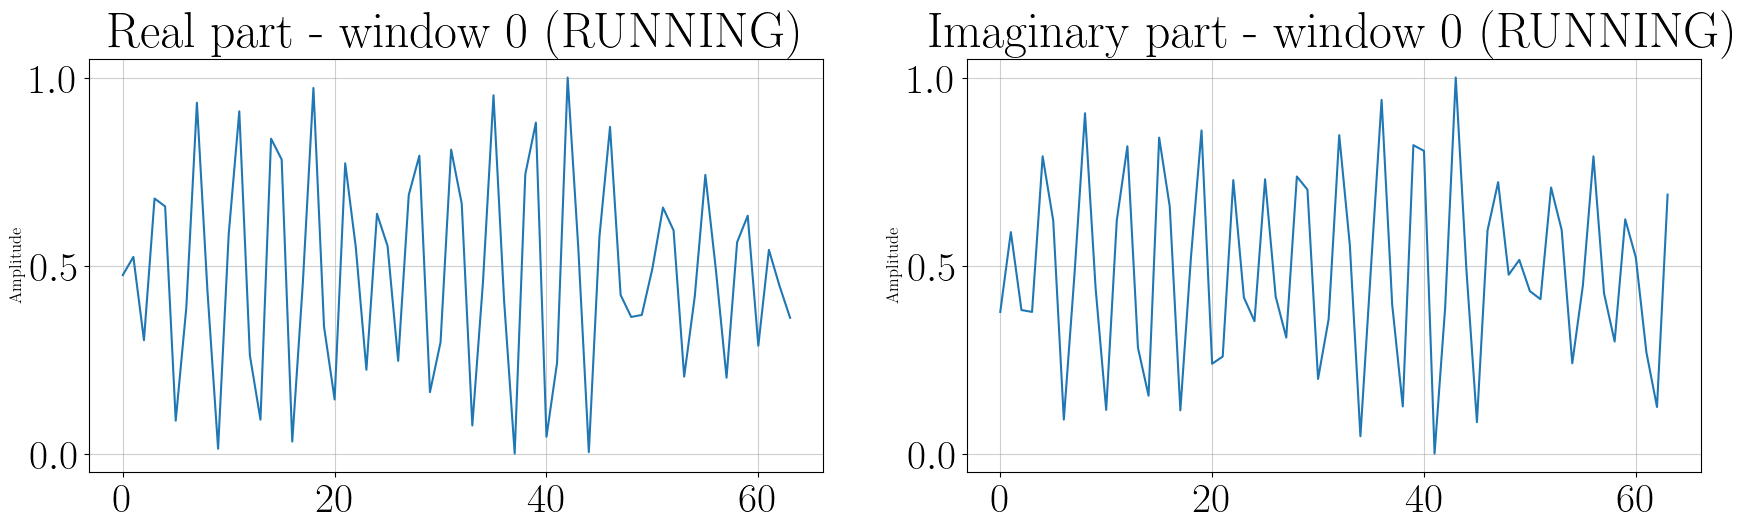

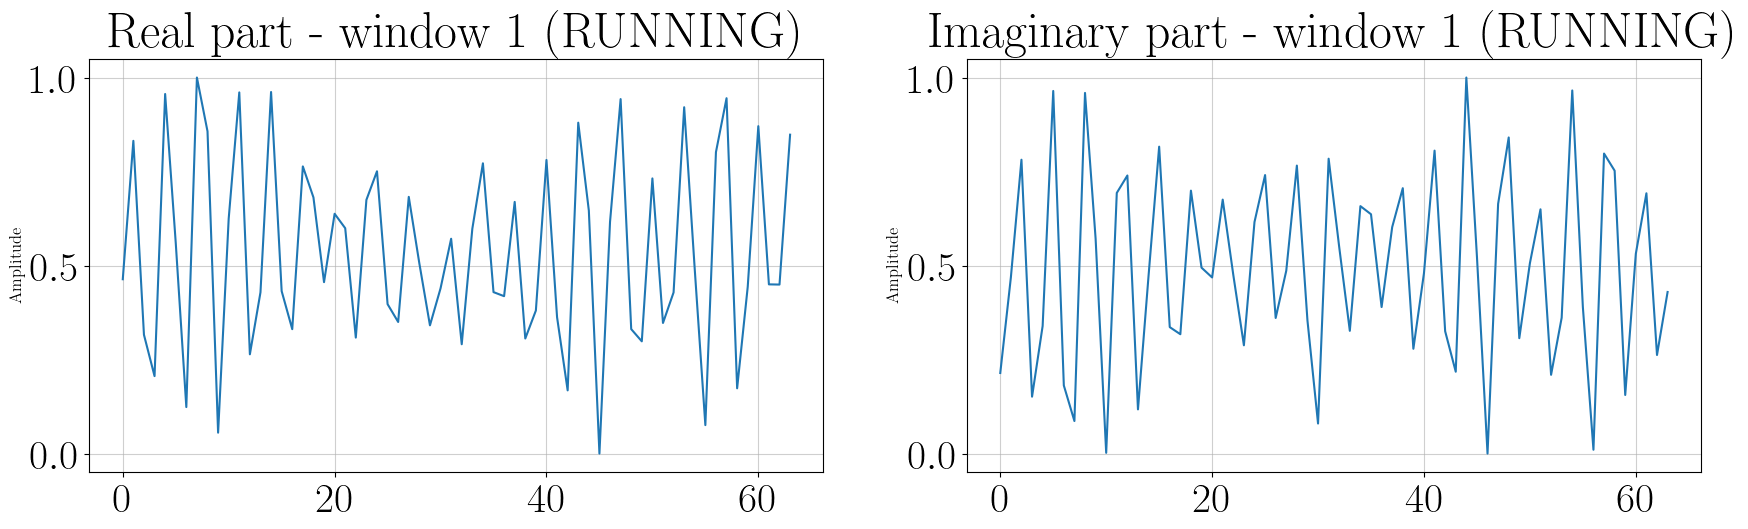

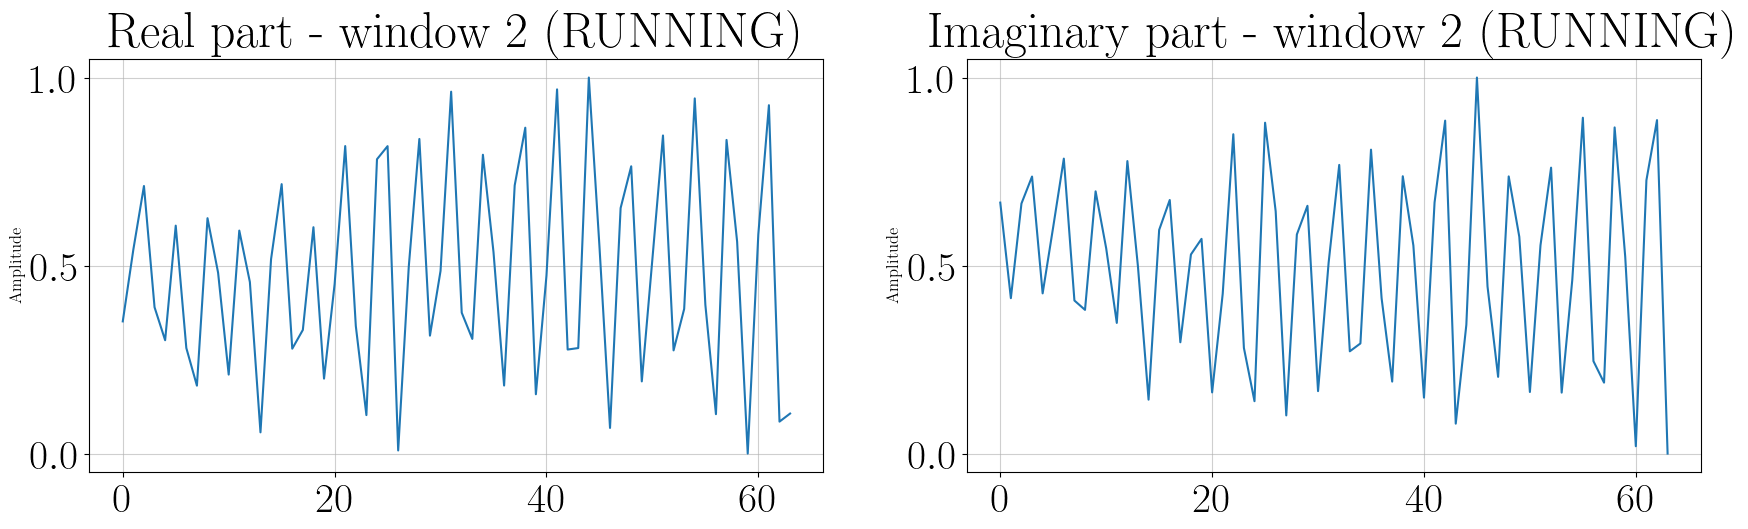

In [33]:
i = np.random.randint(0, len(train_dataset))
X, Y = train_dataset[i][0],train_dataset[i][-1]

for w in range(3):
    fig, ax = plt.subplots(1, 2, figsize=(18,6))

    plt.subplot(121)
    plt.plot(X[0, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(f"Real part - window {w} ({class_dec[int(Y)]})")
    plt.grid()

    plt.subplot(122)
    plt.plot(X[1, w, 0,:].cpu().numpy())
    plt.ylabel('Amplitude',  fontsize=12)
    plt.title(f"Imaginary part - window {w} ({class_dec[int(Y)]})")
    plt.grid()
    plt.tight_layout()

    #plt.savefig('Signal_example1.png')
    plt.show()

### Models definition

In [4]:
# Spiking autoencoder + SNN for classification
class SCAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(SCAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        n_spikes = encoded.abs().mean()
        return n_spikes, decoded, clss

# Standard autoencoder + SNN for classification    
class CAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(CAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        n_spikes = encoded.abs().mean()
        return n_spikes, decoded, clss

# SNN for classifying directly from CIR or delta encoded data    
class SNN_CLSFF(nn.Module):
    def __init__(self, snn):
        super(SNN_CLSFF, self).__init__()
        self.snn = snn

    def forward(self, x):
        clss = self.snn(x)  
        n_spikes = x.abs().mean()
        return n_spikes, x, clss

#### Optimize $\tau$ parameter of the CAE

Values in $[0.1, 0.9]$ with a step size of 0.1. For each value of $\tau$ we made 5 different runs, to compute average and std of sparsity of the encoding and accuracy of classification in the validation set.

In [ ]:
tau_values = np.arange(0.6, 1.0, 0.1)

csv_path = "Tau_vs_accuracy_sparsity.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=["Tau", 
                               "Sparsity_avg", "Sparsity_std", 
                               "Accuracy_avg", "Accuracy_std"])
    
for tau in tau_values:
    print("###############")
    print(f"# Tau = {tau:.1f}")
    print("###############")

    sparsity_ls, accuracy_ls = [], []

    # repeat 5 runs with different initialization
    for run in range(5):
        print(f"  >> Run {run+1}/5")
        torch.cuda.empty_cache()

        autoencoder = network.cae_2(tau = tau,
                                    channels = 64, 
                                    kernel_size = (1,1,3), 
                                    stride = 1
                                    )

        snn = network.snn_1(input_shape = INP_SHAPE, 
                            hidden = [64,128], 
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

        net = CAE(autoencoder, snn).to(device) 
        optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

        trainer = Trainer(
            model = net,
            optimizer = optimizer,
            device = device,
            alpha = 0.95,
            Lambda = 0.0,
            acc_steps = 1,
            patience = 15,
            model_path = None
        )

        trainer.fit(
            train_loader = train_loader,
            val_loader = val_loader,
            epochs = 50
        )

        _, accuracy, sparsity = trainer.evaluate(val_loader)

        sparsity_ls.append(sparsity)
        accuracy_ls.append(accuracy)

    # log results
    new_row = pd.DataFrame([{
        "Tau": tau, 
        "Sparsity_avg": np.mean(sparsity_ls), 
        "Sparsity_std": np.std(sparsity_ls),
        "Accuracy_avg": np.mean(accuracy_ls),
        "Accuracy_std": np.std(accuracy_ls)
    }])

    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv(csv_path, index=False)    

###############
# Tau = 0.6
###############
  >> Run 1/5
Epoch 1 - train_loss: 0.6187 | train_acc: 0.7762 | val_loss: 0.4536 | val_acc: 0.7778
Epoch 6 - train_loss: 0.1009 | train_acc: 0.9792 | val_loss: 0.4285 | val_acc: 0.8681
Epoch 11 - train_loss: 0.0489 | train_acc: 0.9935 | val_loss: 0.7858 | val_acc: 0.8542
Epoch 16 - train_loss: 0.0452 | train_acc: 0.9929 | val_loss: 0.5677 | val_acc: 0.8819
Epoch 21 - train_loss: 0.0303 | train_acc: 0.9976 | val_loss: 0.4990 | val_acc: 0.9236
Epoch 26 - train_loss: 0.0382 | train_acc: 0.9940 | val_loss: 0.7501 | val_acc: 0.8681
Epoch 31 - train_loss: 0.0393 | train_acc: 0.9964 | val_loss: 0.7722 | val_acc: 0.8889
Early stopping at epoch 35
  >> Run 2/5
Epoch 1 - train_loss: 0.5791 | train_acc: 0.7738 | val_loss: 0.3665 | val_acc: 0.8403
Epoch 6 - train_loss: 0.1036 | train_acc: 0.9780 | val_loss: 0.5743 | val_acc: 0.7917
Epoch 11 - train_loss: 0.0768 | train_acc: 0.9833 | val_loss: 0.4379 | val_acc: 0.8681
Epoch 16 - train_loss: 0.0411 | train

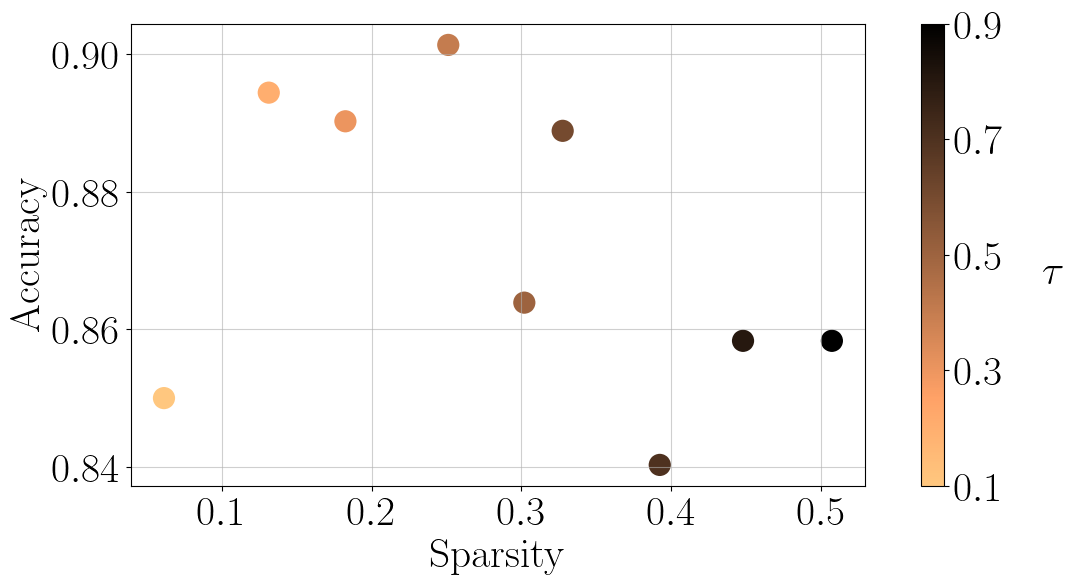

In [ ]:
metrics = pd.read_csv('Tau_vs_accuracy_sparsity.csv')

tau = metrics.Tau.values
sparsity = metrics.Sparsity_avg	.values
avg_acc = metrics.Accuracy_avg.values

plt.figure()
plt.scatter(sparsity, avg_acc, cmap=plt.colormaps.get_cmap('copper_r'),
            c=tau, linewidths=10)
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.grid()
colorbar = plt.colorbar(pad=0.06)#, location='top', orientation='horizontal')
colorbar.set_label(r'$\tau$', labelpad=35, rotation=0)
colorbar.set_ticks([0.1, 0.3, 0.5, 0.7, 0.9])
plt.savefig("Plots/sparsity_vs_acc_tau.png", bbox_inches='tight')
plt.show()

### Train with optimized hyperparams

In [6]:
#metrics = pd.read_csv("models_metrics.csv")
torch.cuda.empty_cache()

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
net = CAE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                acc_steps = 1,
                patience = 20,
                model_path = "./models1/cae_2_snn_1.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

desc = "CAE (cae_2): 2 conv_layers, channels=64, kernel=(1,1,3), stride=1, tau=0.4,  \
        SNN (snn_1): 3 layers, neurons=[64,128], timesteps=29, kernel=(1,1,4) \
        stride=(1,2,2), beta=0.9, thr=0.8, learn_beta_thr = True, surr_grad = atan\\ \
        optimizer=Adam, lr=1e-3, epochs=50, patience=15"

row_data = {"name": "CAE-SNN1",
            "path": "cae_2_snn_1.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

#df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
#df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 0.3461 | train_acc: 0.7710 | val_loss: 0.1897 | val_acc: 0.9337
Epoch 6 - train_loss: 0.1205 | train_acc: 0.9471 | val_loss: 0.1184 | val_acc: 0.9564
Epoch 11 - train_loss: 0.0834 | train_acc: 0.9797 | val_loss: 0.2596 | val_acc: 0.8917
Epoch 16 - train_loss: 0.0712 | train_acc: 0.9869 | val_loss: 0.2749 | val_acc: 0.8018
Epoch 21 - train_loss: 0.0693 | train_acc: 0.9839 | val_loss: 0.2360 | val_acc: 0.8588
Early stopping at epoch 25


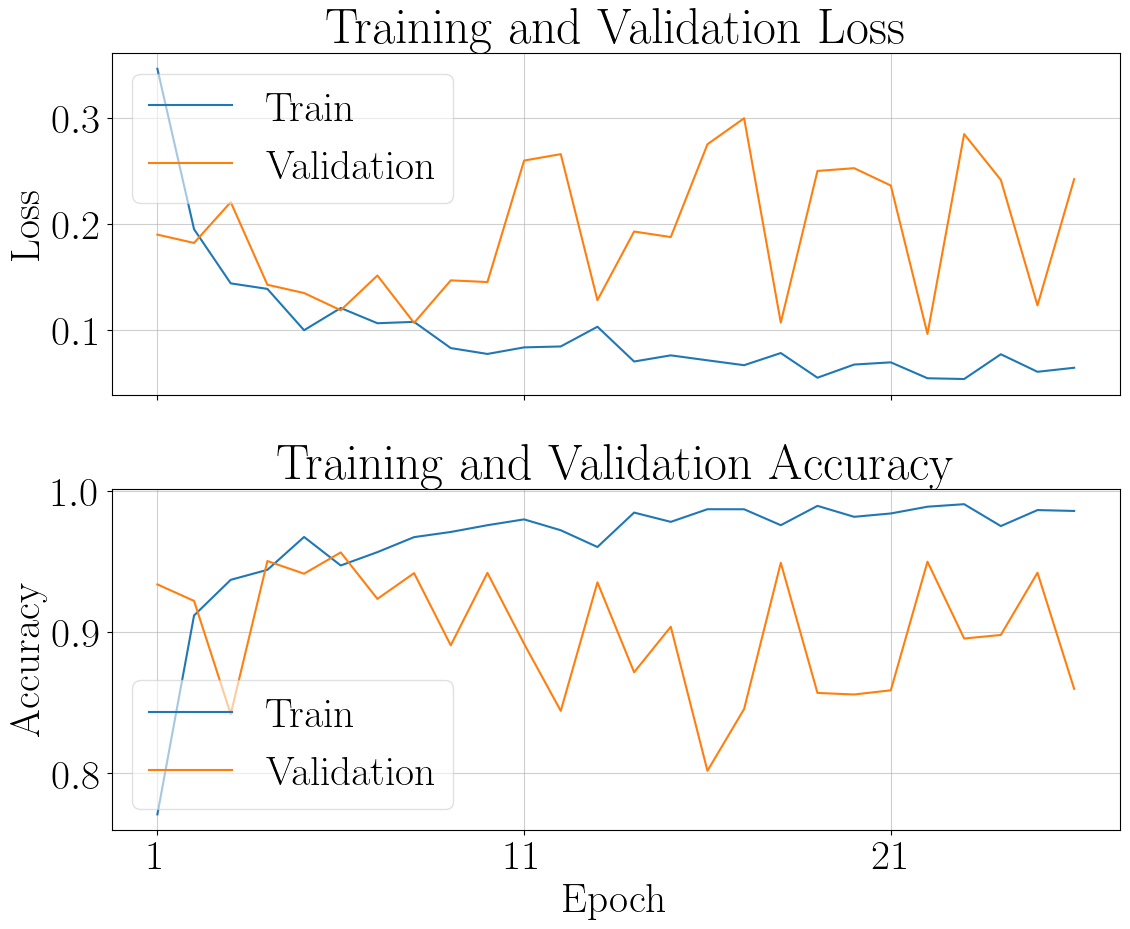

In [7]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

### Results on test set

In [8]:
path = "./models1/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
net = CAE(autoencoder, snn).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

CAE(
  (autoencoder): cae_2(
    (encoder): Sequential(
      (0): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
      (4): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Sigmoid()
    )
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in)

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                model_path = path
        )

acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.9560
Precision: 0.9527
Recall: 0.9646              
F1 score: 0.9584

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.97      0.94      0.95        79
     RUNNING       0.93      0.95      0.94        41
     SITTING       0.97      1.00      0.98        28
       HANDS       0.94      0.97      0.96        34

    accuracy                           0.96       182
   macro avg       0.95      0.96      0.96       182
weighted avg       0.96      0.96      0.96       182



In [39]:
df.loc[df["name"]=="CAE-SNN1", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

#### Plot the confusion matrix

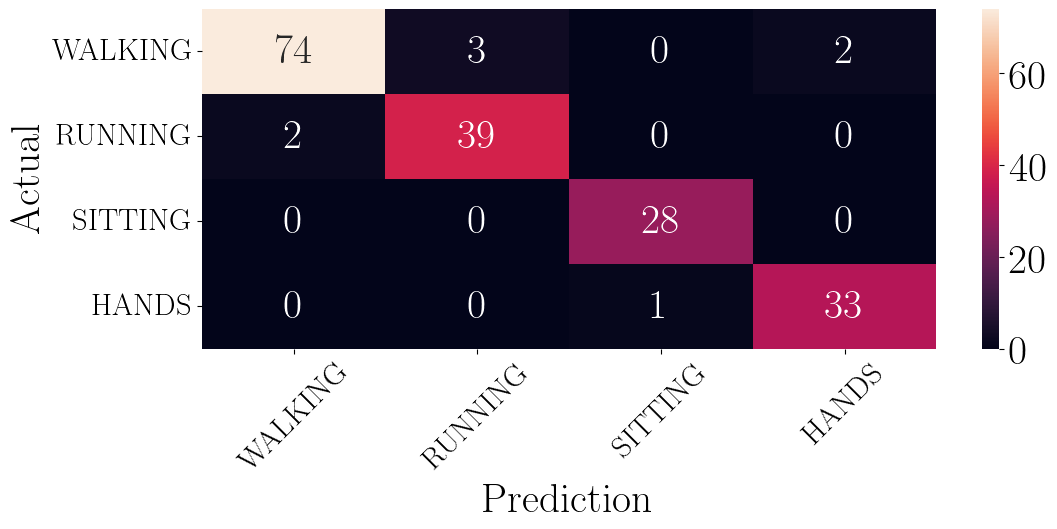

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_cae2_snn_1.png", bbox_inches='tight')
plt.show()

#### Number of trainable parameters and weight of the model

In [16]:
summary(net, input_size=(1, 2, 232, 10, 64))


Layer (type:depth-idx)                   Output Shape              Param #
CAE                                      --                        --
├─cae_2: 1-1                             [1, 2, 232, 10, 64]       --
│    └─Sequential: 2-1                   [1, 2, 232, 10, 64]       --
│    │    └─Conv3d: 3-1                  [1, 64, 232, 10, 64]      448
│    │    └─BatchNorm3d: 3-2             [1, 64, 232, 10, 64]      128
│    │    └─ReLU: 3-3                    [1, 64, 232, 10, 64]      --
│    │    └─Conv3d: 3-4                  [1, 2, 232, 10, 64]       386
│    │    └─BatchNorm3d: 3-5             [1, 2, 232, 10, 64]       4
│    │    └─HeavisideCustom: 3-6         [1, 2, 232, 10, 64]       --
│    └─Sequential: 2-2                   [1, 2, 232, 10, 64]       --
│    │    └─ConvTranspose3d: 3-7         [1, 64, 232, 10, 64]      448
│    │    └─BatchNorm3d: 3-8             [1, 64, 232, 10, 64]      128
│    │    └─ReLU: 3-9                    [1, 64, 232, 10, 64]      --
│    │    └

### Aircraft marshaling

Compare the encoding with the procedure in this paper

In [17]:
# Create the encoded datasets
train_loader_enc = DataLoader(
                            train_dataset,
                            batch_size=batch,
                            shuffle=True,
                            num_workers=2,
                            collate_fn=utils_fn.binary_encoding,
                            )

val_loader_enc = DataLoader(
                            val_dataset,
                            batch_size=batch,
                            collate_fn=utils_fn.binary_encoding,
                            )

test_loader_enc = DataLoader(
                            test_dataset,
                            batch_size=1,
                            collate_fn=utils_fn.binary_encoding,
                            )

#### Train the snn_1 network with delta thresholded encoded data

In [23]:
#metrics = pd.read_csv("models_metrics.csv")
classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = 0.95,
                Lambda = 1.0,
                acc_steps = 1,
                patience = 15,
                model_path = "./models1/delta_snn_1_1.pt" 
        )

trainer.fit(
                train_loader = train_loader_enc,
                val_loader = val_loader_enc,
                epochs = 50
        )

desc = 'Delta_thresholding encoding +\
        SNN (snn_1): 3 layers, neurons=[64,128], timesteps=29, kernel=(1,1,4) \
        stride=(1,2,2), beta=0.9, thr=0.8, learn_beta_thr = True, surr_grad = atan\\ \
        optimizer=Adam, lr=1e-3, epochs=50, patience=15'

row_data = {"name": "Delta",
            "path": "delta_snn_1.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

#df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
#df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 0.3785 | train_acc: 0.6585 | val_loss: 0.3657 | val_acc: 0.5908
Epoch 6 - train_loss: 0.0311 | train_acc: 0.9726 | val_loss: 0.5473 | val_acc: 0.7205
Epoch 11 - train_loss: 0.0026 | train_acc: 0.9988 | val_loss: 0.5110 | val_acc: 0.7521
Epoch 16 - train_loss: 0.0005 | train_acc: 1.0000 | val_loss: 0.7818 | val_acc: 0.7168
Epoch 21 - train_loss: 0.0005 | train_acc: 1.0000 | val_loss: 0.8208 | val_acc: 0.7307
Epoch 26 - train_loss: 0.0000 | train_acc: 1.0000 | val_loss: 0.9072 | val_acc: 0.7234
Early stopping at epoch 26


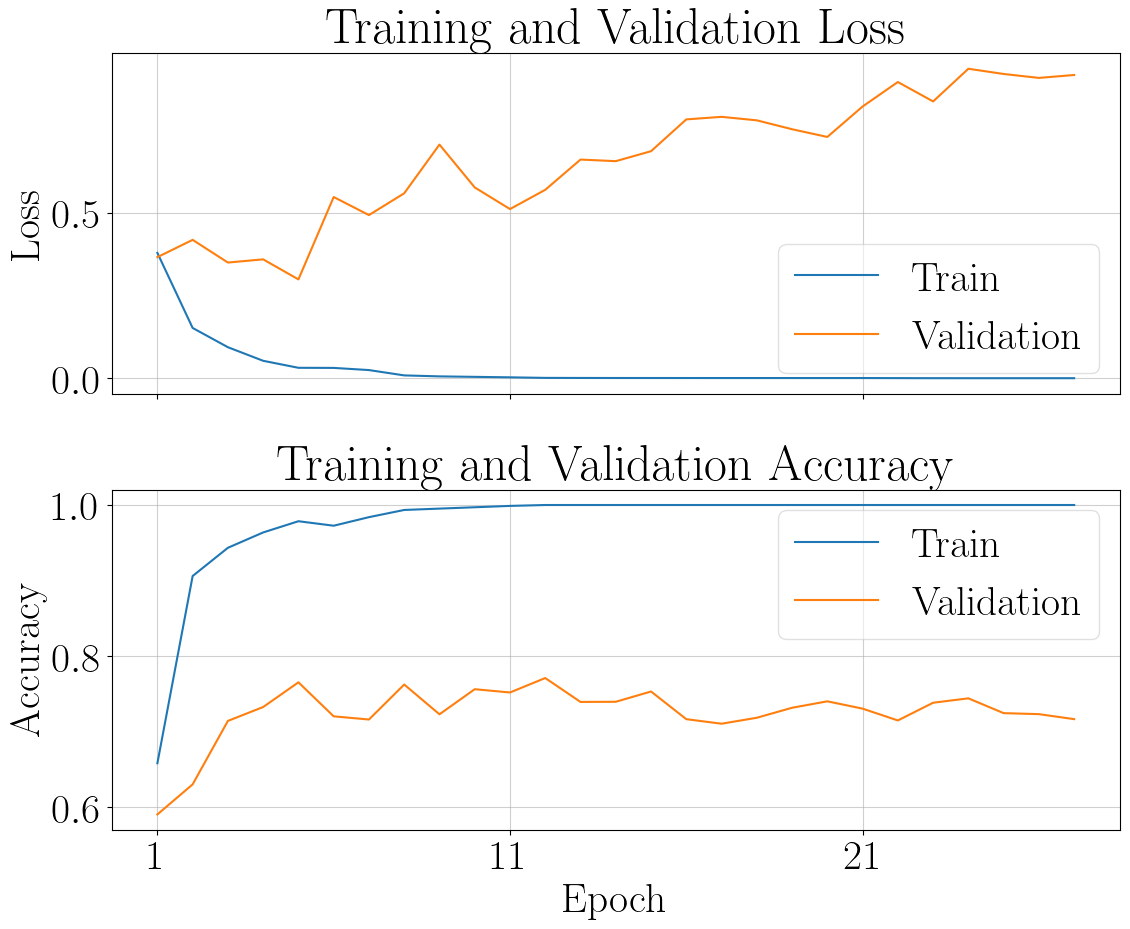

In [24]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of delta encoded + SNN

In [25]:
path = "./models1/delta_snn_1_1.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [26]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader_enc,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.7857
Precision: 0.8078
Recall: 0.7505              
F1 score: 0.7528

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.87      0.94      0.90        79
     RUNNING       0.53      0.68      0.60        41
     SITTING       0.97      1.00      0.98        28
       HANDS       0.87      0.38      0.53        34

    accuracy                           0.79       182
   macro avg       0.81      0.75      0.75       182
weighted avg       0.81      0.79      0.78       182



In [92]:
df.loc[df["name"]=="Delta", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

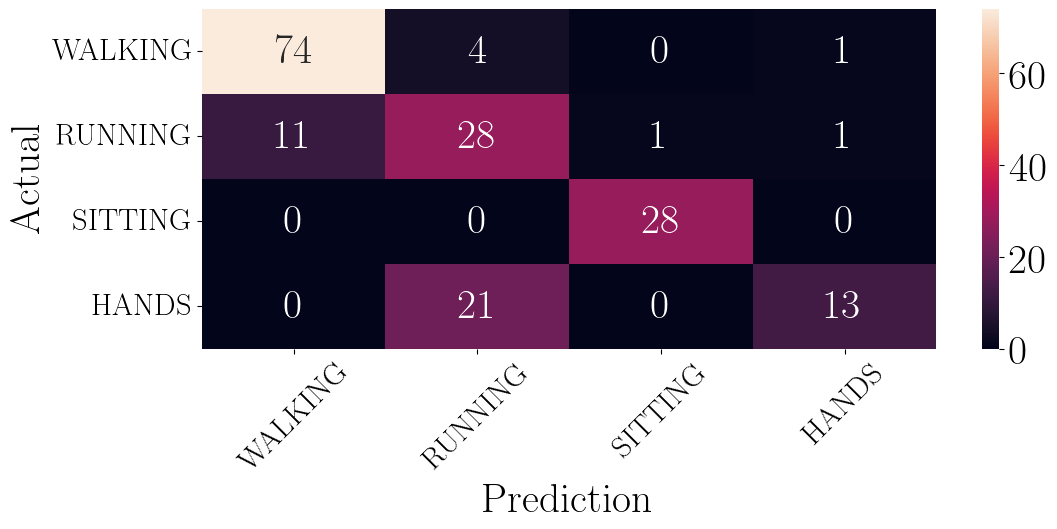

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_delta_snn.pdf", bbox_inches='tight')
plt.show()

### Sparsity of various encoding methods

In [32]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
cae = CAE(autoencoder, snn).to(device)
cae.load_state_dict(checkpoint['model_state_dict'])
cae.eval()

path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surrogate.atan()
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

scae = SCAE(autoencoder, snn).to(device)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [34]:
loss_fn = torch.nn.MSELoss()

loss_cae, loss_scae = 0, 0
sparsity_cae, sparsity_scae = 0, 0

with torch.no_grad():
        for X, _, _ in test_loader:
            X = X.to(device).float()
            
            spk_percent, decoded, spk_out = scae(X)
            spk_percent1, decoded1, spk_out1 = cae(X)

            loss_scae += loss_fn(decoded.squeeze(0), X)
            loss_cae += loss_fn(decoded1.squeeze(0), X)

            sparsity_scae += 1 - spk_percent.item()
            sparsity_cae += 1 - spk_percent1.item()
            
        loss_cae = loss_cae / len(test_loader)
        loss_scae = loss_scae / len(test_loader)
        sparsity_cae = sparsity_cae / len(test_loader)
        sparsity_scae = sparsity_scae / len(test_loader)

sparsity_delta = 0
with torch.no_grad():
        for X in test_loader_enc:
            X = X[0]
            sparsity_delta += 1 - X.abs().mean().item()

sparsity_delta =  sparsity_delta / len(test_loader_enc)

print(f"Reconstruction error of CAE: {loss_cae.item():.4f}")
print(f"Reconstruction error of SCAE: {loss_scae.item():.4f}\n")
print(f"Average sparsity of CAE encoding: {sparsity_cae:.4f}")
print(f"Average sparsity of SCAE encoding: {sparsity_scae:.4f}")
print(f"Average sparsity of Delta encoding: {sparsity_delta:.4f}")

Reconstruction error of CAE: 0.0530
Reconstruction error of SCAE: 0.0500

Average sparsity of CAE encoding: 0.2653
Average sparsity of SCAE encoding: 0.8180
Average sparsity of Delta encoding: 0.7171


In [39]:
metrics.loc[metrics.name=='SCAE-SNN1', 'sparsity'] = round(sparsity_scae, 4)
metrics.loc[metrics.name=='CAE-SNN1', 'sparsity'] = round(sparsity_cae, 4)
metrics.loc[metrics.name=='Delta', 'sparsity'] = round(sparsity_delta, 4)
metrics.to_csv("models_metrics.csv", index=False)

### Train a Direct-SNN with linear layers

In [ ]:
# SNN for classifying directly from CIR or delta encoded data    
class SNN_CLSFF(nn.Module):
    def __init__(self, snn):
        super(SNN_CLSFF, self).__init__()
        self.snn = snn

    def forward(self, x):
        clss = self.snn(x)  
        n_spikes = x.abs().mean()
        return n_spikes, x, clss

In [ ]:
#metrics = pd.read_csv("models_metrics.csv")
classifier =  network.snn_2(input_shape = INP_SHAPE, 
                            hidden = [64,128, 256],
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                acc_steps = 1,
                patience = 20,
                model_path = "./models1/direct_snn_2.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

desc = 'Direct SNN (snn_2): 4 linear layers, neurons=[64,128,256], timesteps=29, kernel=(1,1,4) \
        stride=(1,2,2), beta=0.9, thr=0.8, learn_beta_thr = True, surr_grad = atan\\ \
        optimizer=Adam, lr=1e-3, epochs=50, patience=15'

row_data = {"name": "Direct-SNN2",
            "path": "direct_snn_2.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

#df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
#df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 0.5497 | train_acc: 0.3013 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 6 - train_loss: 0.5297 | train_acc: 0.2955 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 11 - train_loss: 0.5373 | train_acc: 0.2941 | val_loss: 0.6412 | val_acc: 0.2272
Epoch 16 - train_loss: 0.5285 | train_acc: 0.2623 | val_loss: 0.7220 | val_acc: 0.2272
Epoch 21 - train_loss: 0.4144 | train_acc: 0.3647 | val_loss: 0.4653 | val_acc: 0.3816
Epoch 26 - train_loss: 0.3513 | train_acc: 0.4680 | val_loss: 0.5493 | val_acc: 0.4239
Epoch 31 - train_loss: 0.3299 | train_acc: 0.4751 | val_loss: 0.5022 | val_acc: 0.4122
Epoch 36 - train_loss: 0.3037 | train_acc: 0.4954 | val_loss: 0.5548 | val_acc: 0.3715
Epoch 41 - train_loss: 0.3014 | train_acc: 0.5389 | val_loss: 0.5662 | val_acc: 0.3607
Epoch 46 - train_loss: 0.2977 | train_acc: 0.5362 | val_loss: 0.5940 | val_acc: 0.4894
Early stopping at epoch 48


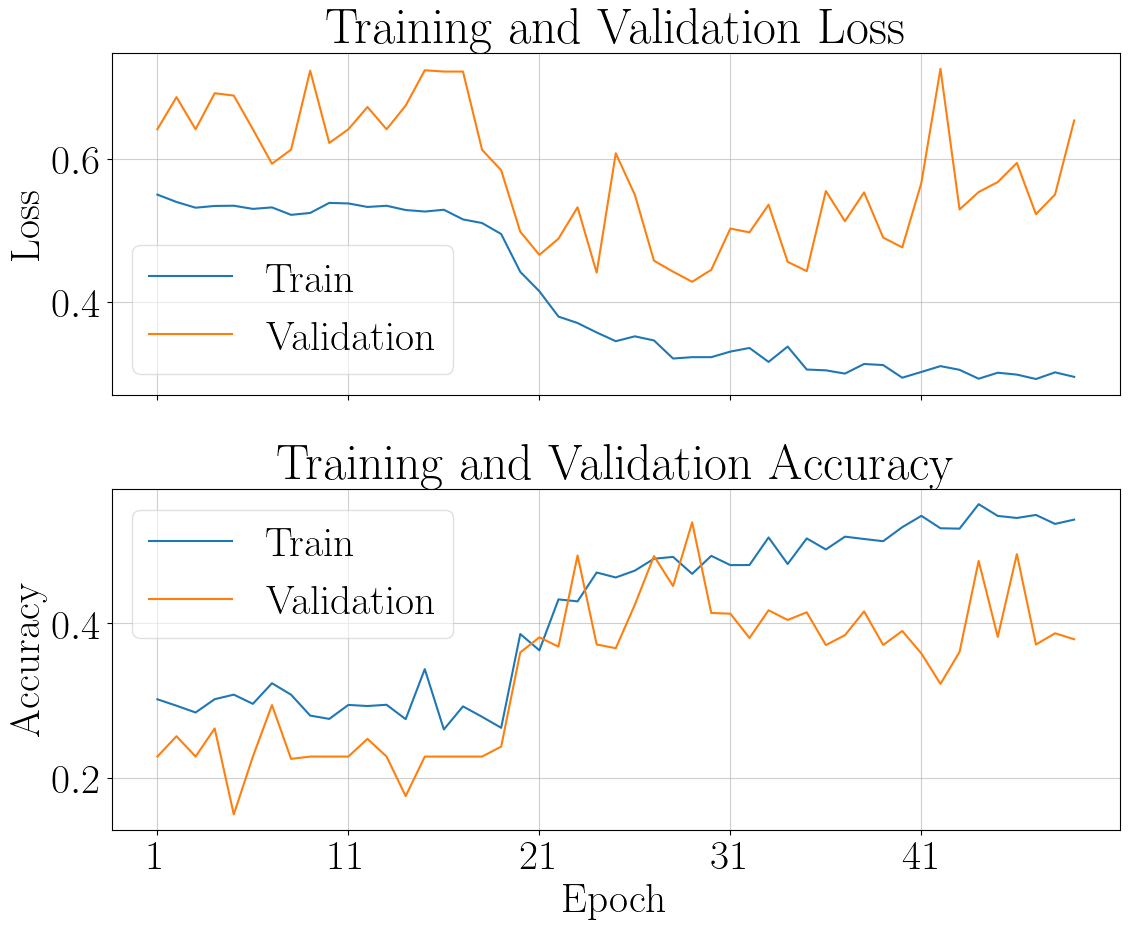

In [51]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of Direct-SNN

In [52]:
path = "./models1/direct_snn_2.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_2(input_shape = INP_SHAPE, 
                            hidden = [64,128, 256],
                            timesteps = 29,
                            kernel = (1,1,4),
                            stride = (1,2,2),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_2(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden1): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden1): Leaky()
    (fc_hidden2): Linear(in_features=128, out_features=256, bias=True)
    (lif_hidden2): Leaky()
    (fc_out): Linear(in_features=4096, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [53]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.4396
Precision: 0.4596
Recall: 0.4494              
F1 score: 0.4152

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.63      0.43      0.51        79
     RUNNING       0.30      0.51      0.38        41
     SITTING       0.40      0.68      0.51        28
       HANDS       0.50      0.18      0.26        34

    accuracy                           0.44       182
   macro avg       0.46      0.45      0.42       182
weighted avg       0.50      0.44      0.43       182



In [105]:
df.loc[df["name"]=="Direct-SNN2", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

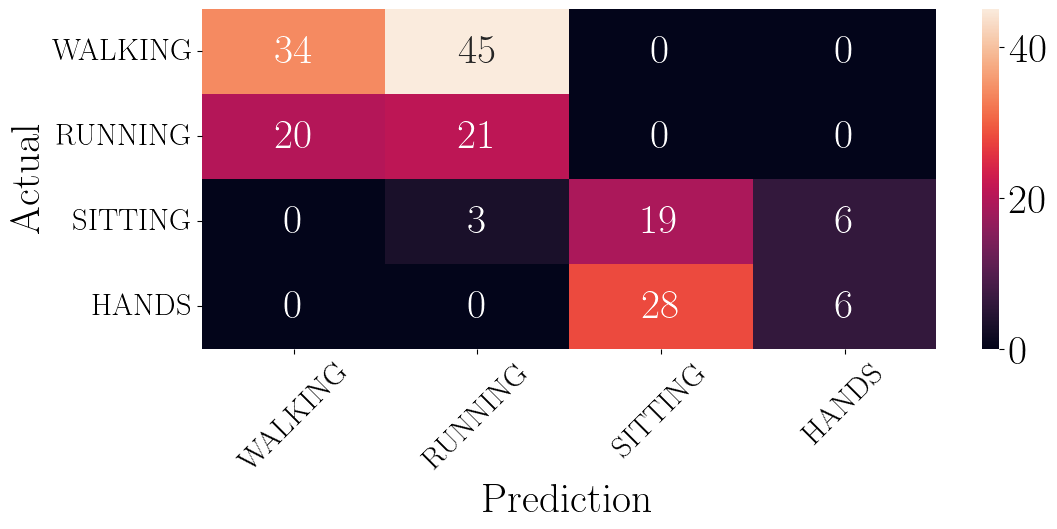

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_direct_snn_2.pdf", bbox_inches='tight')
plt.show()

### Train a Direct-SNN with conv layer

In [70]:
#metrics = pd.read_csv("models_metrics.csv")
torch.cuda.empty_cache()
classifier =  network.snn_conv1(input_shape = INP_SHAPE, 
                            channels = [128],
                            timesteps = 29,
                            kernel = (1,1,3),
                            stride = (1,1,1),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                acc_steps = 1,
                patience = 15,
                model_path = "./models1/direct_snn_conv_1_1.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

desc = 'Direct SNN (snn_conv2): 3 conv + 1 linear, channels=[64,128,128], timesteps=232, kernel=(1,1,3) \
        stride=(1,1,1), beta=0.9, thr=0.8, learn_beta_thr = True, surr_grad = atan\\ \
        optimizer=Adam, lr=1e-3, epochs=50, patience=15'

row_data = {"name": "Direct-SNN-Conv3_1",
            "path": "direct_snn_conv_3_1.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

#df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
#df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 4.3176 | train_acc: 0.2359 | val_loss: 7.8122 | val_acc: 0.2272
Epoch 6 - train_loss: 4.3895 | train_acc: 0.2344 | val_loss: 7.8122 | val_acc: 0.2272
Epoch 11 - train_loss: 4.3895 | train_acc: 0.2344 | val_loss: 7.8122 | val_acc: 0.2272
Early stopping at epoch 15


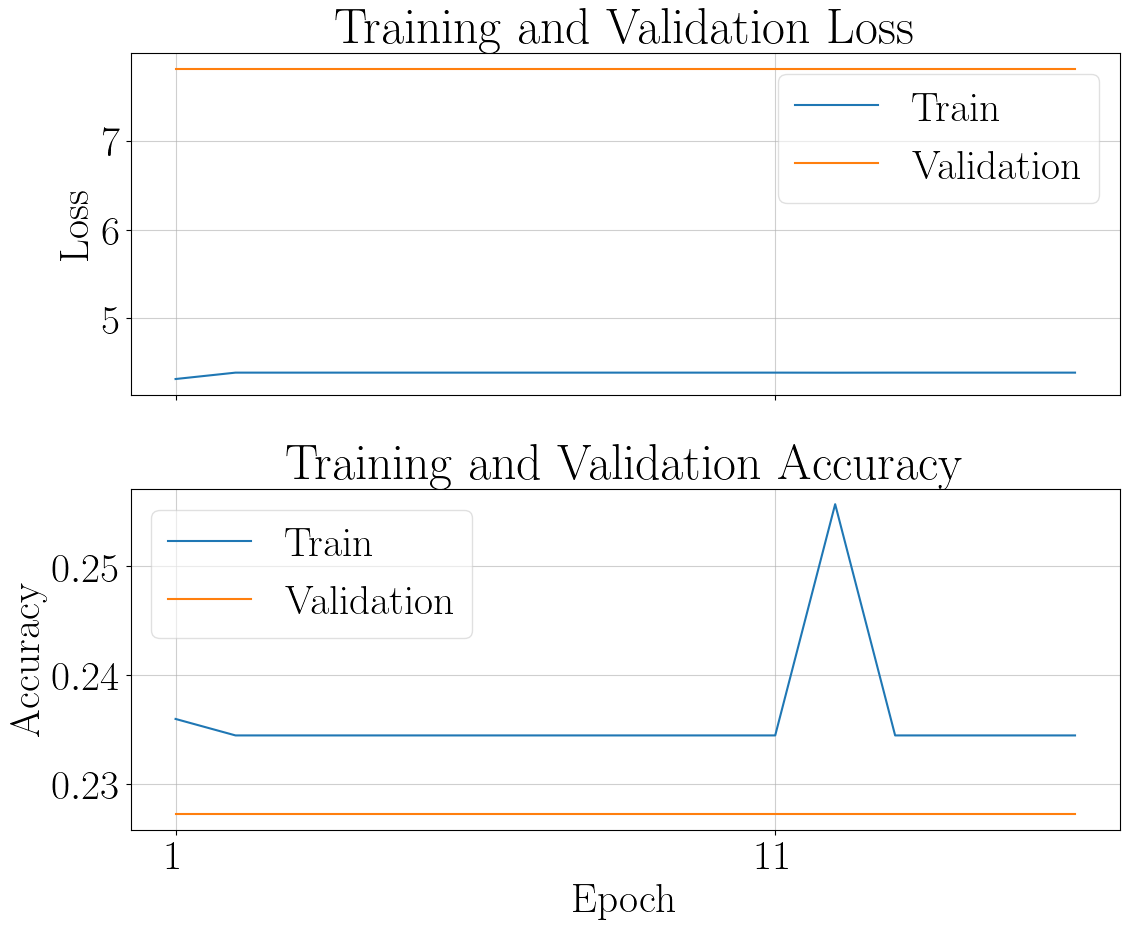

In [71]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set of Direct-SNN (conv layers)

In [65]:
path = "./models1/direct_snn_conv_1.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_conv1(input_shape = INP_SHAPE, 
                            channels = [64],
                            timesteps = 29,
                            kernel = (1,1,3),
                            stride = (1,1,1),
                            beta = 0.9,
                            threshold = 0.8,
                            learn_thr = True, 
                            learn_beta = True,
                            surr_grad = surrogate.atan()
                            )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_conv1(
    (conv): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lif): Leaky()
    (fc_out): Linear(in_features=327680, out_features=4, bias=True)
    (lif_out): Leaky()
  )
)

In [66]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                                )

AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.43      1.00      0.61        79
     RUNNING       0.00      0.00      0.00        41
     SITTING       0.00      0.00      0.00        28
       HANDS       0.00      0.00      0.00        34

    accuracy                           0.43       182
   macro avg       0.11      0.25      0.15       182
weighted avg       0.19      0.43      0.26       182



/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [17]:
df.loc[df["name"]=="Direct-SNN-Conv3_1", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

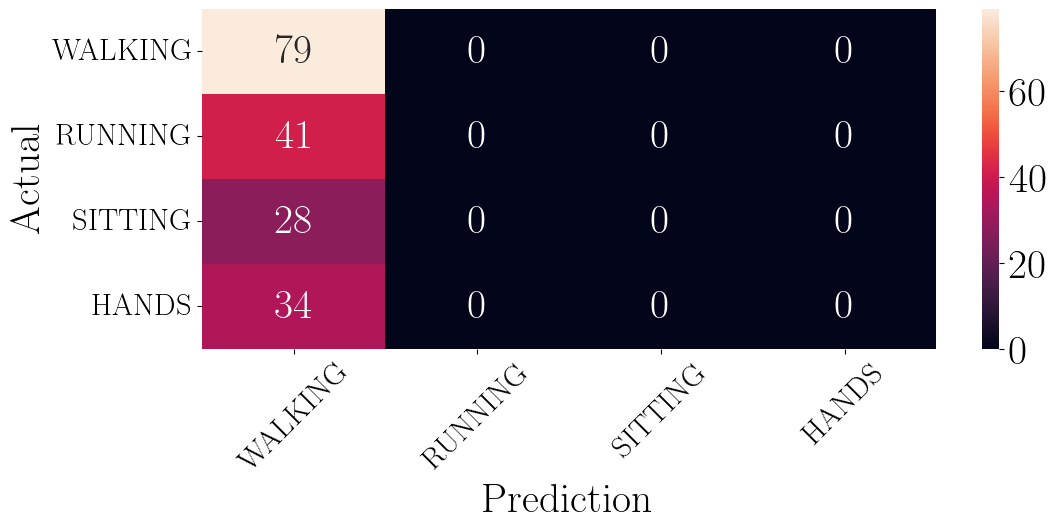

In [67]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_scae_snn_1.png", bbox_inches='tight')
plt.show()

In [62]:
summary(net, input_size=(1, 2, 232, 10, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SNN_CLSFF                                --                        --
├─snn_conv2: 1-1                         [29, 1, 4]                --
│    └─Conv3d: 2-1                       [1, 64, 8, 10, 64]        448
│    └─BatchNorm3d: 2-2                  [1, 64, 8, 10, 64]        128
│    └─Leaky: 2-3                        [1, 64, 8, 10, 64]        2
│    └─Conv3d: 2-4                       [1, 128, 8, 10, 64]       24,704
│    └─BatchNorm3d: 2-5                  [1, 128, 8, 10, 64]       256
│    └─Leaky: 2-6                        [1, 128, 8, 10, 64]       2
│    └─Linear: 2-7                       [1, 4]                    2,621,444
│    └─Leaky: 2-8                        [1, 4]                    1
│    └─Conv3d: 2-9                       [1, 64, 8, 10, 64]        (recursive)
│    └─BatchNorm3d: 2-10                 [1, 64, 8, 10, 64]        (recursive)
│    └─Leaky: 2-11                       [1, 64, 8, 10, 

### Train of CNN network (DISC paper)

In [81]:
metrics = pd.read_csv("models_metrics.csv")
torch.cuda.empty_cache()
classifier =  network.cnn_disc()

net = SNN_CLSFF(classifier).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                acc_steps = 1,
                patience = 15,
                model_path = "./models/disc_cnn.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

desc = 'DISC (cnn_disc): 6 conv, channels=[2,8,16,32,64,128], kernel=3, stride=2, padding=1 \
        + 2 linear, neurons=[64,4]. Dropout(0.2) before each linear. Relu activation'

row_data = {"name": "Disc-CNN",
            "path": "disc_cnn.pt",
            "description": desc,
            "params": utils_fn.count_params(net)}

df = pd.concat([metrics, pd.DataFrame([row_data])], ignore_index=True)
df.to_csv("models_metrics.csv", index=False)

Epoch 1 - train_loss: 1.3433 | train_acc: 0.3982 | val_loss: 1.4451 | val_acc: 0.2986
Epoch 6 - train_loss: 1.3377 | train_acc: 0.4060 | val_loss: 1.3617 | val_acc: 0.3819
Epoch 11 - train_loss: 1.3377 | train_acc: 0.4060 | val_loss: 1.3617 | val_acc: 0.3819
Epoch 16 - train_loss: 1.3377 | train_acc: 0.4060 | val_loss: 1.3617 | val_acc: 0.3819
Early stopping at epoch 18


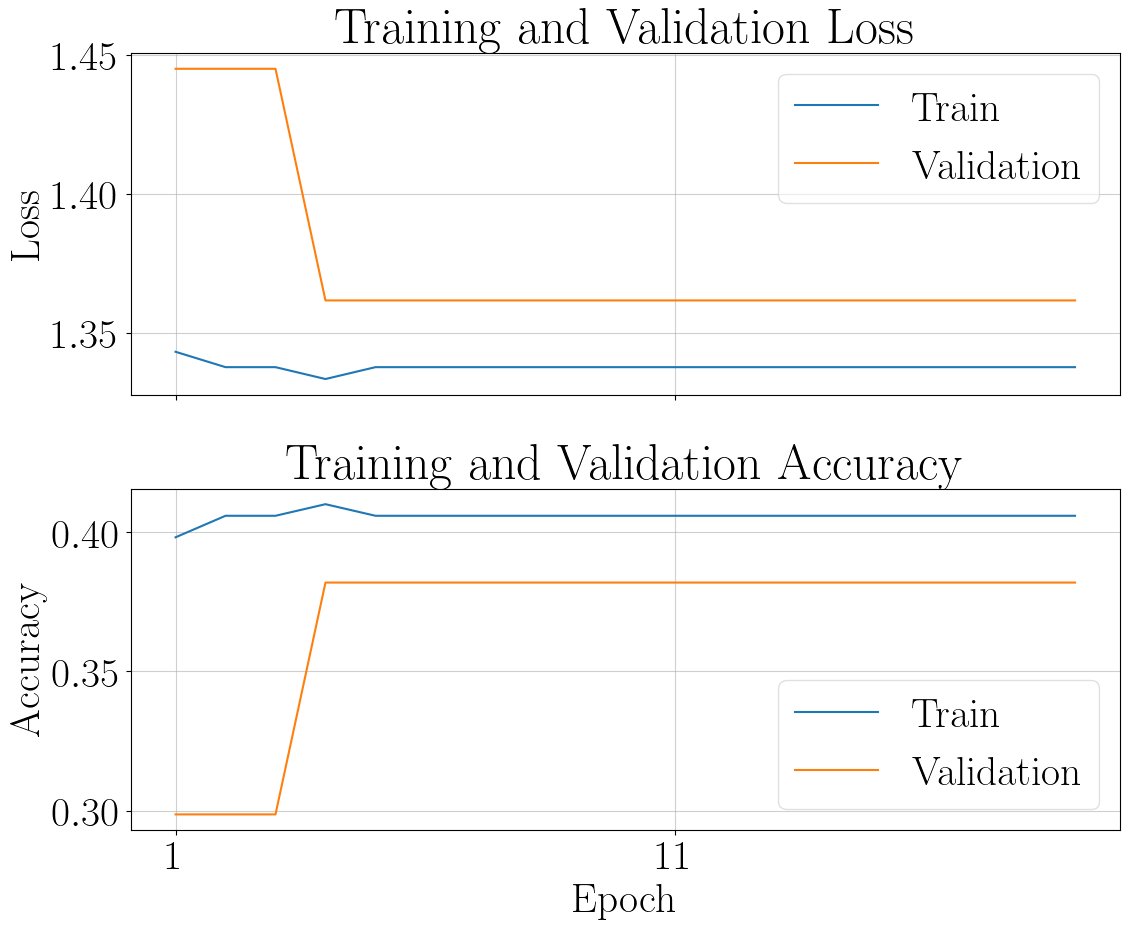

In [82]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

#### Results on test set

In [83]:
path = "./models/disc_cnn.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.cnn_disc()

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): cnn_disc(
    (conv_layers): Sequential(
      (0): Conv3d(2, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
      (2): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): ReLU()
      (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (5): ReLU()
      (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (7): ReLU()
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): ReLU()
      (10): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (11): ReLU()
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (dense1): Linear(in_features=512, out_features=64, bias=True)
    (dense2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [85]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                                )

df.loc[df["name"]=="Disc-CNN", ["f1", "precision", "recall"]] = [f1, prec, rec]
df.to_csv("models_metrics.csv", index=False)

AVERAGE TYPE: macro

Accuracy: 0.4341
Precision: 0.1085
Recall: 0.2500              
F1 score: 0.1513

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.43      1.00      0.61        79
     RUNNING       0.00      0.00      0.00        41
     SITTING       0.00      0.00      0.00        28
       HANDS       0.00      0.00      0.00        34

    accuracy                           0.43       182
   macro avg       0.11      0.25      0.15       182
weighted avg       0.19      0.43      0.26       182



/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/eleonora/envsnn1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


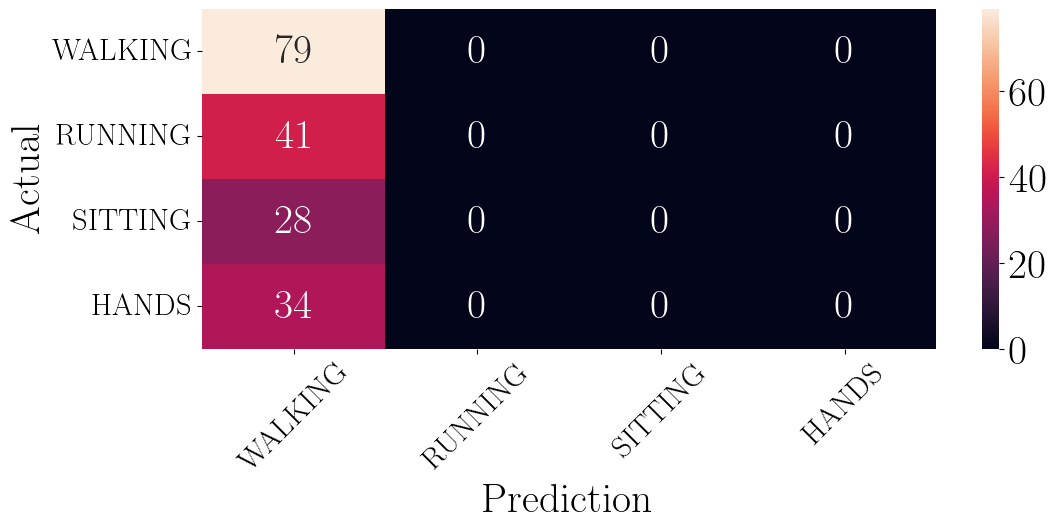

In [86]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_scae_snn_1.png", bbox_inches='tight')
plt.show()

### Average number of spikes per neuron

In [4]:
class snn_1(nn.Module):

    def __init__(self, input_dim, hidden, timesteps, n_classes, surr_grad, learn_thr, learn_beta):
        super(snn_1, self).__init__()

        self.input_dim = input_dim        
        self.hidden = hidden
        self.timesteps = timesteps
        self.n_classes = n_classes
        self.surr_grad = surr_grad
        self.learn_thr = learn_thr
        self.learn_beta = learn_beta

        # layer input
        self.fc_in = nn.Linear(in_features=input_dim, out_features=self.hidden[0])
        self.lif_in = snn.Leaky(beta=torch.rand(self.hidden[0]), 
                                threshold=torch.rand(self.hidden[0]),
                                learn_beta=self.learn_beta, learn_threshold=self.learn_thr, 
                                spike_grad=self.surr_grad)

        # layer hidden
        self.fc_hidden = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden = snn.Leaky(beta=torch.rand(self.hidden[1]), 
                                    threshold=torch.rand(self.hidden[1]),
                                    learn_beta=self.learn_beta, learn_threshold=self.learn_thr, 
                                    spike_grad=self.surr_grad)
        
        # layer output
        self.fc_out = nn.Linear(in_features=self.hidden[1], out_features=n_classes)
        self.li_out = snn.Leaky(beta=torch.rand(n_classes), threshold=1.0,
                                #learn_threshold=self.learn_thr, 
                                learn_beta=self.learn_beta,
                                spike_grad=self.surr_grad)

    def forward(self, x):

        mem_in = self.lif_in.init_leaky()
        mem_hid = self.lif_hidden.init_leaky()
        mem_out = self.li_out.init_leaky()
        
        # Record the final layer
        spk_rec = []
        mem_rec = []

        spike_count1 = torch.zeros(self.hidden[0], self.timesteps)
        spike_count2 = torch.zeros(self.hidden[1], self.timesteps)
        spike_count3 = torch.zeros(self.n_classes, self.timesteps)

        for step in range(self.timesteps): # n. timesteps = n. windows

            x_tmstp = torch.reshape(x[:, :, step, :, :], (x.shape[0], -1)) # ~ [batch, 2*10*64]

            cur_in = self.fc_in(x_tmstp) # ~ [batch, 16]
            spk_in, mem_in = self.lif_in(cur_in, mem_in)
            spike_count1[:, step] = spk_in

            cur_hid = self.fc_hidden(spk_in) # ~ [batch, 1]
            spk_hid, mem_hid = self.lif_hidden(cur_hid, mem_hid)
            spike_count2[:, step] = spk_hid

            cur_out = self.fc_out(spk_hid) # ~ [batch, num_classes]
            spk_out, mem_out = self.li_out(cur_out, mem_out)
            spike_count3[:, step] = spk_out

            spk_rec.append(spk_out)
            mem_rec.append(mem_out)

        return torch.stack(spk_rec, dim=0), spike_count1, spike_count2, spike_count3 #, torch.stack(mem_rec, dim=0)

In [5]:
classifier =  snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'], 
                    timesteps = N_WIN,
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)

path = 'models/model_snn_clss_delta_thr.pt'
classifier.load_state_dict(torch.load(path))
classifier.eval()

snn_1(
  (fc_in): Linear(in_features=1280, out_features=128, bias=True)
  (lif_in): Leaky()
  (fc_hidden): Linear(in_features=128, out_features=64, bias=True)
  (lif_hidden): Leaky()
  (fc_out): Linear(in_features=64, out_features=4, bias=True)
  (li_out): Leaky()
)

In [28]:
tot_spike_count = 0

with torch.no_grad():
        for X, _, y in test_loader_enc:
            X = X.to(device)
        
            spk_out, spike_count1,  spike_count2, spike_count3 = classifier(X.float())

            tot_spike_count += (spike_count1.sum()+spike_count2.sum()+spike_count3.sum())/((128+64+4)*232)

tot_spike_count.item() / len(test_loader_enc)


0.14836201174505825

In [ ]:
spike_count1.mean()

tensor(0.1311)

In [10]:
spike_count2.mean()

tensor(0.1331)

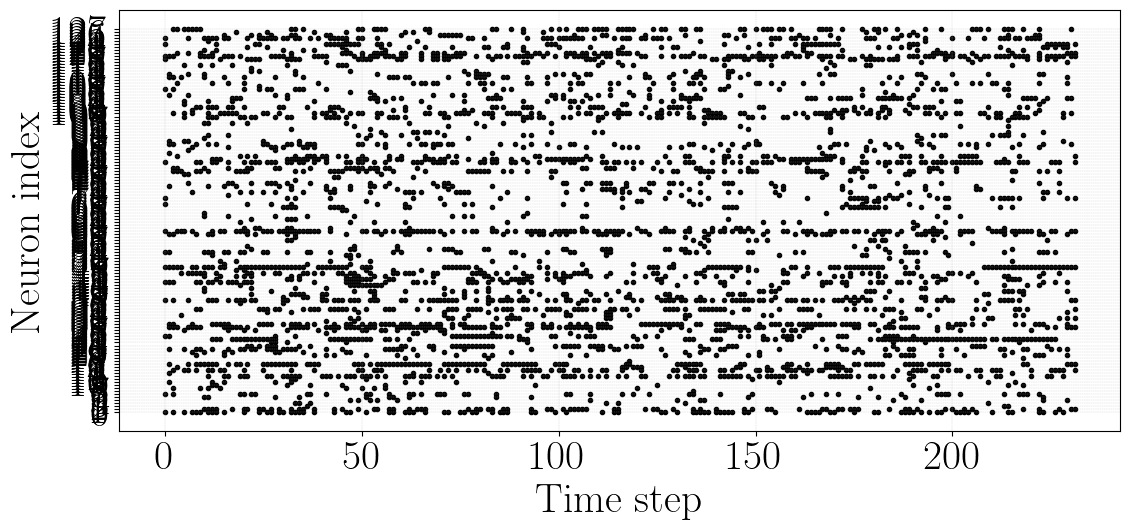

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count1, 0, 1)) # layer input

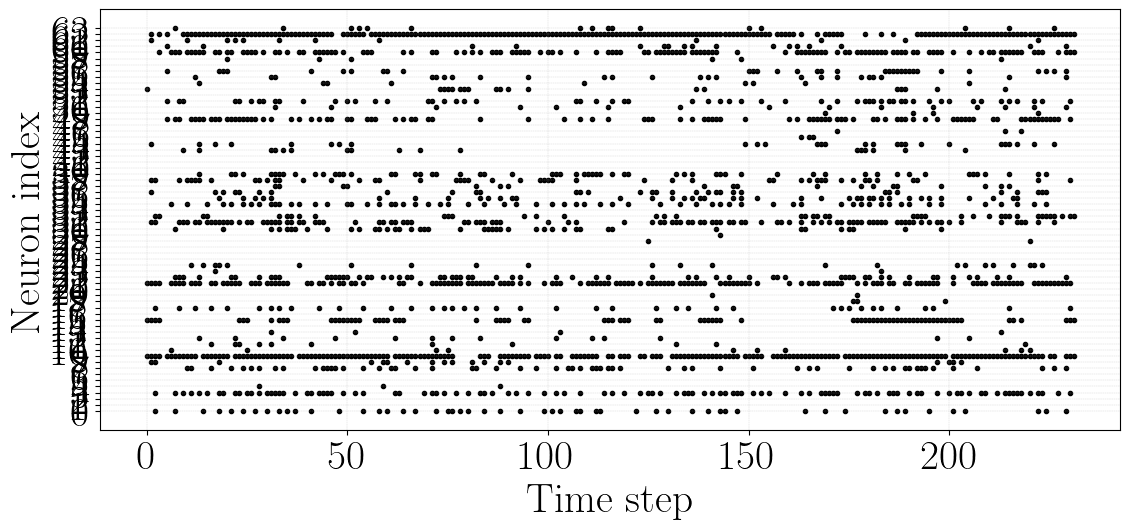

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count2, 0, 1)) # hidden layer

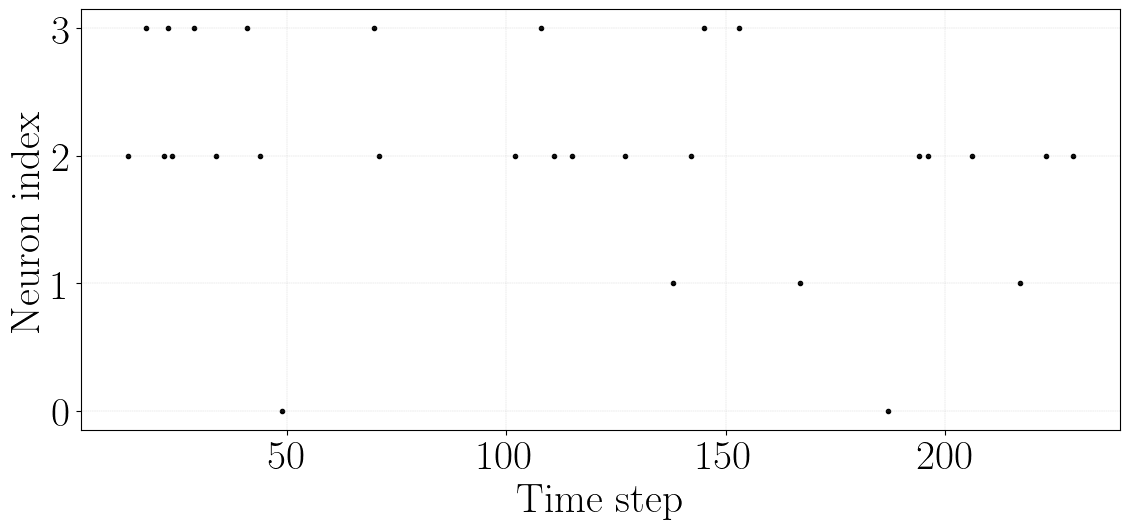

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count3, 0, 1)) # output layer

#### nostro approccio

In [ ]:
class CAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(CAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss, x1, x2, x3 = self.snn(encoded)  
        return encoded, decoded, clss, x1, x2, x3

In [16]:
path = "./models/model_opt_2.pt"
autoencoder = network.cae_3(
                        tau = params_cae['tau'], 
                        channels = params_cae['feature_maps'], 
                        kernel_size = params_cae['kernel'], 
                        stride = params_cae['stride'], 
                        padding = params_cae['padding']
                        ).to(device)

snn =  snn_1(
                    input_dim = 2*10*64, 
                    hidden = params_snn['hidden_layers'],
                    timesteps = N_WIN, 
                    n_classes = params_snn['num_classes'], 
                    surr_grad = params_snn['surrogate_grad'],
                    learn_thr = params_snn['learn_thr'], 
                    learn_beta = params_snn['learn_beta']
                    ).to(device)
    
net = LSE(autoencoder, snn).to(device)
net.load_state_dict(torch.load(path))
net.eval()

LSE(
  (autoencoder): cae_3(
    (encoder): Sequential(
      (0): Conv3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): Conv3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Tanh()
      (6): Conv3d(128, 2, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=same)
      (7): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): HeavisideCustom()
    )
    (decoder): Sequential(
      (0): ConvTranspose3d(2, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Tanh()
      (3): ConvTranspose3d(128, 128, kernel_size=(1, 1, 5), stride=(1, 1, 1), padding=(0, 0, 2))
      (4): BatchNorm3d(12

In [26]:
tot_spike_count = 0

with torch.no_grad():
        for X, _, y in test_loader:
            X = X.to(device)
        
            encoded, dec, clss, spike_count1, spike_count2, spike_count3 = net(X.float())

            tot_spike_count += (spike_count1.sum()+spike_count2.sum()+spike_count3.sum())/((128+64+4)*232)

tot_spike_count.item() / len(test_loader)


0.16434373526737608

In [27]:
print(spike_count1.mean())
print(spike_count2.mean())
print(spike_count3.mean())

tensor(0.1617)
tensor(0.2218)
tensor(0.0302)


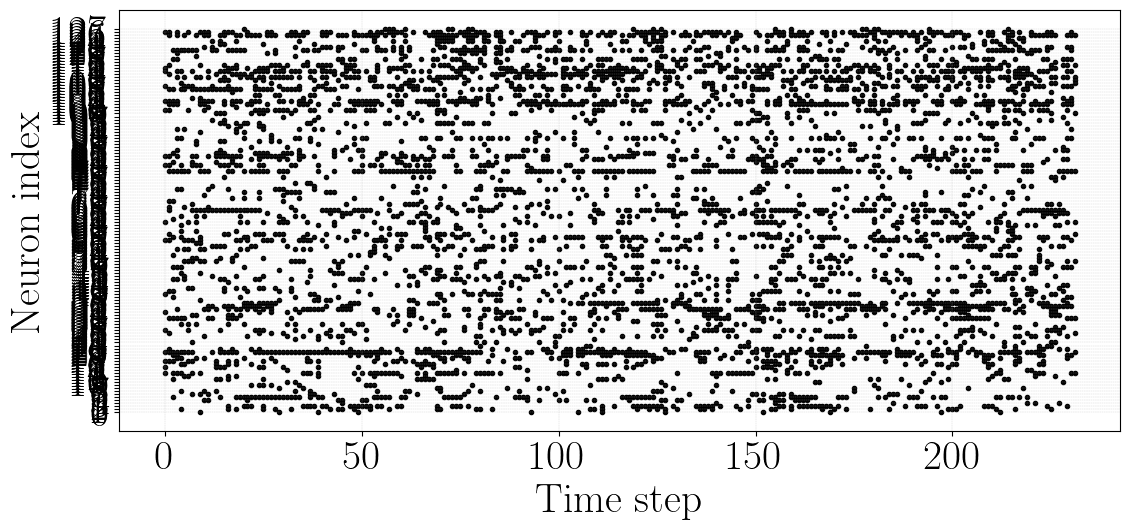

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count1, 0, 1)) # input layer

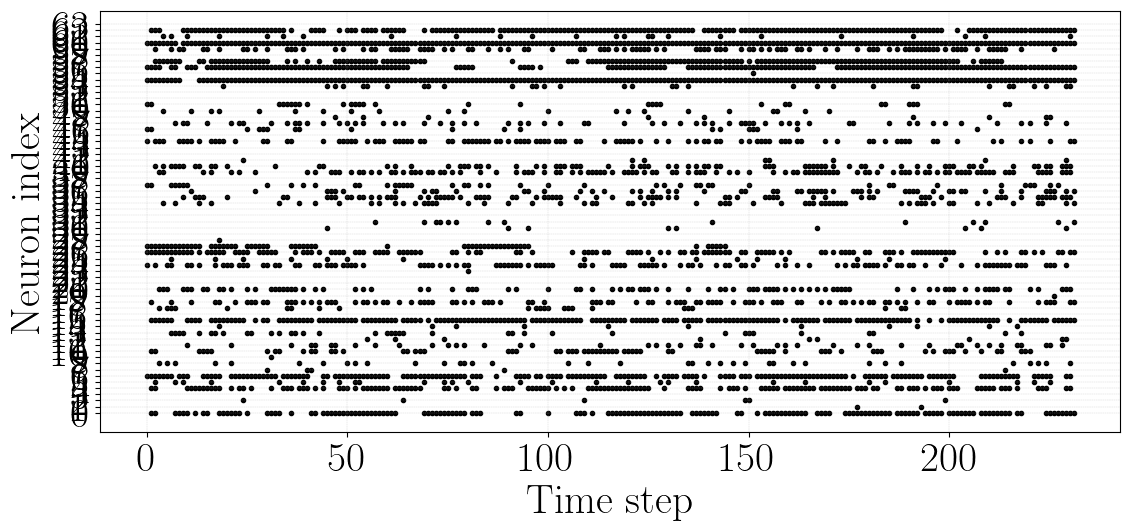

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count2, 0, 1)) # hidden layer

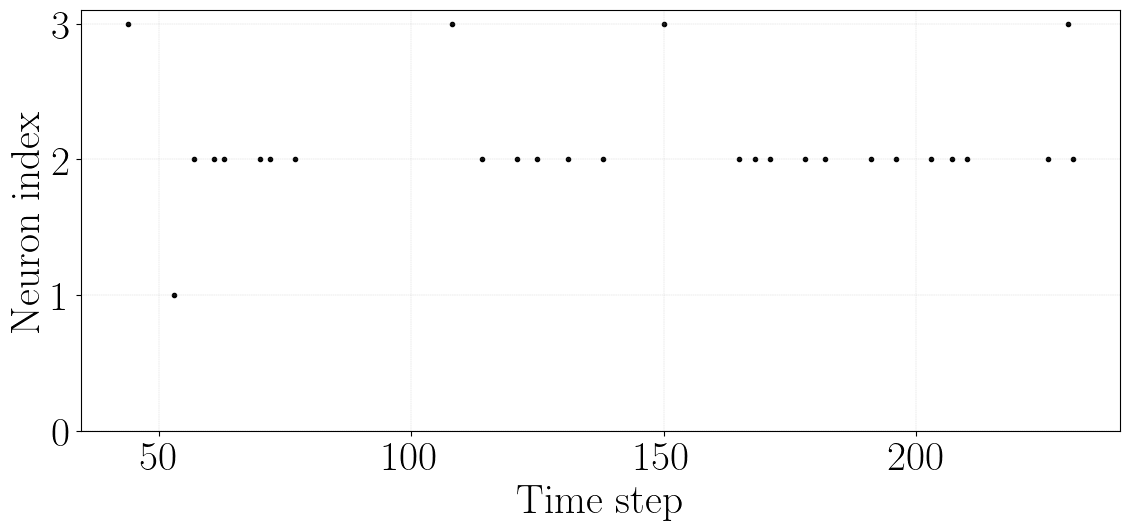

In [ ]:
utils_fn.raster_plot(torch.transpose(spike_count3, 0, 1)) # output layer

### Inference time on test set

In [63]:
path = "./models/cae_2_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.cae_2(tau = 0.4, 
                           channels = 64, 
                           kernel_size = (1,1,3), 
                           stride = 1, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )
    
cae = CAE(autoencoder, snn).to(device)
cae.load_state_dict(checkpoint['model_state_dict'])
cae.eval()

path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surrogate.atan()
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

scae = SCAE(autoencoder, snn).to(device)
scae.load_state_dict(checkpoint['model_state_dict'])
scae.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [70]:
n_runs = 100

cae_enc_times, cae_cls_times = [], []
scae_enc_times, scae_cls_times = [], []

for _ in tqdm.tqdm(range(n_runs)):
    # CAE+SNN inference
    enc, clss = utils_fn.inference_time(cae, test_loader, device)
    cae_enc_times.append(enc)
    cae_cls_times.append(clss)
    
    # SCAE+SNN inference
    enc, clss = utils_fn.inference_time(scae, test_loader, device)
    scae_enc_times.append(enc)
    scae_cls_times.append(clss)

# Compute averages
cae_enc_avg = np.mean(cae_enc_times)
cae_cls_avg = np.mean(cae_cls_times)
scae_enc_avg = np.mean(scae_enc_times)
scae_cls_avg = np.mean(scae_cls_times)

# Print results
print(f"Average inference time over {n_runs} runs:")
print(f"CAE+SNN: encoding {cae_enc_avg:.4f} - classification {cae_cls_avg:.4f}")
print(f"SCAE+SNN: encoding {scae_enc_avg:.4f} - classification {scae_cls_avg:.4f}")

100%|██████████| 100/100 [13:26<00:00,  8.07s/it]

Average inference time over 100 runs:
CAE+SNN: encoding 0.0006 - classification 0.0186
SCAE+SNN: encoding 0.0012 - classification 0.0184


In [74]:
path = "./models/delta_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

classifier =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SNN_CLSFF(classifier).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SNN_CLSFF(
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_features=155, out_features=64, bias=True)
    (lif_in): Leaky()
    (fc_hidden): Linear(in_features=64, out_features=128, bias=True)
    (lif_hidden): Leaky()
    (fc_out): Linear(in_features=2048, out_features=4, bias=True)
    (li_out): Leaky()
  )
)

In [78]:
n_runs = 100
encoding_time = []
encoding_time_runs = []

with torch.no_grad():
    for _ in tqdm.tqdm(range(n_runs)):
        for X, _, _ in test_loader_enc:

            start_time_enc = time.time()
            clss = net.snn(X.to(device).float())
            encoding_time.append(time.time() - start_time_enc)

        encoding_time_runs.append(np.mean(encoding_time))
        
print(f"Inference time of delta encoding method {np.mean(encoding_time_runs):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:41<00:00,  4.01s/it]

Inference time of delta encoding method 0.0187


Aggiungere pure inference time per Direct SNN


### Number of MACCs and ACCs